In [43]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import ImageDraw,ImageFont

In [1]:
# Parses the xml file, extracts the bounding bpxes
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find('filename').text  # e.g., '000001.jpg'
    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = int(obj.find('name').text)  # assuming numeric labels
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, boxes, labels

In [33]:
def parse_all_annotations(xml_dir, image_dir):
    all_data = []
    for file in os.listdir(xml_dir):
        if file.endswith(".xml"):
            xml_path = os.path.join(xml_dir, file)
            filename, boxes, labels = parse_voc_xml(xml_path)

            # Ignore flipped images
            if '_flip' in filename:
                continue

            image_path = os.path.normpath(os.path.join(image_dir, os.path.basename(filename)))

            if os.path.exists(image_path):  # only include if image exists
                all_data.append({
                    'image_path': image_path,
                    'boxes': boxes,
                    'labels': labels
                })

    return all_data

def split_dataset(all_data, train_ratio=0.8, val_ratio=0.1):
    
    train_val_data, test_data = train_test_split(all_data, test_size=1 - (train_ratio + val_ratio), random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)
    return train_data, val_data, test_data

In [34]:
class VOCDataset(Dataset):
    
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform if transform else T.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert("RGB")
        image = self.transform(image)

        boxes = torch.tensor(sample['boxes'], dtype=torch.float32)
        labels = torch.tensor(sample['labels'], dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return image, target

Batch image shape: torch.Size([3, 594, 491])
Batch target sample: {'boxes': tensor([[ 23., 190., 128., 309.],
        [378., 339., 492., 447.],
        [252., 404., 373., 529.]]), 'labels': tensor([2, 3, 5])}


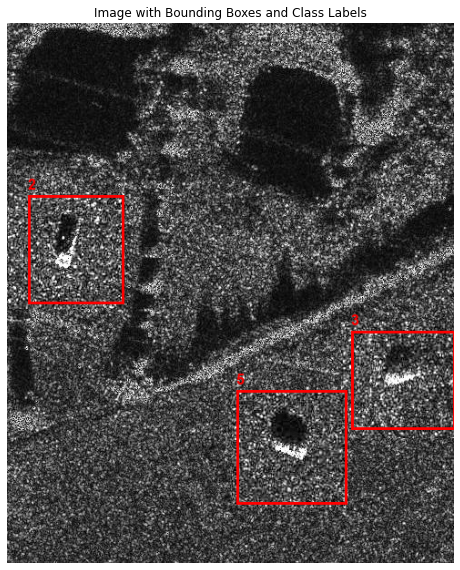

In [ ]:
if __name__ == "__main__":

    xml_dir = r"C:\Users\wills\Desktop\VOC2007\Annotations"
    image_dir = r"C:\Users\wills\Desktop\VOC2007\JPEGImages"

    # Load and filter data
    all_data = parse_all_annotations(xml_dir, image_dir)

    # Split into train/val/test
    train_data, val_data, test_data = split_dataset(all_data)

    # Create dataset and loader
    train_dataset = VOCDataset(train_data)
    def collate_fn(batch): return tuple(zip(*batch))
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

    # Get one batch
    for images, targets in train_loader:
        image_tensor = images[0]
        target = targets[0]
        break

    print("Batch image shape:", image_tensor.shape)
    print("Batch target sample:", target)

    # Convert image tensor to PIL image
    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_pil = Image.fromarray((image_np * 255).astype('uint8'))

    # Draw bounding boxes and labels
    draw = ImageDraw.Draw(image_pil)

    # Load font
    font = ImageFont.truetype(font="arialbd.ttf", size=16)  # Replace with "DejaVuSans.ttf" if Arial not available

    for box, label in zip(target['boxes'], target['labels']):
        box = list(box.numpy())
        label = str(int(label.item()))

        # Draw bounding box
        draw.rectangle(box, outline="red", width=3)

        # Position text just above the top-left corner of the box
        label_offset = 5  # vertical space above the box
        x, y = box[0], box[1] - font_size - label_offset
        draw.text((x, y), label, fill="red", font=font)

    # Show image
    plt.figure(figsize=(8, 10))
    plt.imshow(image_pil)
    plt.axis("off")
    plt.title("Image with Bounding Boxes and Class Labels")
    plt.show()

In [66]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Choose from yolov8n/s/m/l/x
model.train(data="data.yaml", epochs=50, imgsz=640)

Ultralytics 8.3.155  Python-3.8.1 torch-2.4.1+cpu CPU (Intel Core(TM) i7-8700 3.20GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

100%|███████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 8.38MB/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     


  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256,

train: Scanning C:\Users\wills\Desktop\VOC2007\yolo_dataset\labels\train... 720 images, 56 backgrounds, 0 corrupt: 100%


train: New cache created: C:\Users\wills\Desktop\VOC2007\yolo_dataset\labels\train.cache
val: Fast image access  (ping: 0.10.1 ms, read: 15.25.1 MB/s, size: 181.7 KB)


val: Scanning C:\Users\wills\Desktop\VOC2007\yolo_dataset\labels\val... 90 images, 7 backgrounds, 0 corrupt: 100%|█████

val: New cache created: C:\Users\wills\Desktop\VOC2007\yolo_dataset\labels\val.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.197      4.815      2.028         48        640: 100%|██████████| 45/45 [03:06<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<0

                   all         90        138     0.0113      0.838      0.122     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.568      3.383      1.415         42        640: 100%|██████████| 45/45 [02:51<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.146        0.3      0.194     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.488      2.899      1.342         34        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138       0.24      0.811      0.324      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.431      2.661      1.325         48        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.184      0.614      0.315      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.415      2.441      1.297         43        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.193      0.571      0.273      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.388      2.271      1.274         47        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.322      0.825      0.454        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.319      2.084      1.228         52        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138       0.43      0.783      0.595       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.337      1.985      1.298         34        640: 100%|██████████| 45/45 [02:51<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.402      0.734      0.482      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.354      1.926      1.277         53        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.382      0.805      0.612      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.294      1.785      1.266         48        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.376      0.752      0.542      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.292      1.649      1.242         32        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.478      0.776      0.688      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.25      1.509      1.214         35        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.479      0.747       0.65        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.262      1.485      1.231         55        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.649      0.754      0.784      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.229      1.434      1.236         45        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.498      0.702      0.682      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G       1.24      1.346      1.232         38        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.645      0.773       0.81      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.235      1.313      1.229         37        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.623       0.86      0.817      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.238      1.282      1.229         25        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.675      0.774      0.845      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.197      1.256      1.212         38        640: 100%|██████████| 45/45 [02:49<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.525      0.699      0.706      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.213      1.228      1.205         44        640: 100%|██████████| 45/45 [02:49<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.596      0.728      0.708       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.206      1.202      1.213         26        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.693      0.844      0.877      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.202      1.136      1.226         48        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.787      0.804      0.888      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.179      1.118      1.207         55        640: 100%|██████████| 45/45 [03:00<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.769      0.803       0.88      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.157      1.069      1.197         38        640: 100%|██████████| 45/45 [03:01<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.643      0.836       0.82      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.163      1.072      1.217         33        640: 100%|██████████| 45/45 [03:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.637       0.83      0.846       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.172      1.029      1.204         36        640: 100%|██████████| 45/45 [02:53<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.624      0.837      0.829      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.162     0.9944      1.203         47        640: 100%|██████████| 45/45 [02:57<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138        0.7      0.821      0.854      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.127     0.9784      1.182         53        640: 100%|██████████| 45/45 [02:58<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.592      0.779      0.788      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.131     0.9698      1.203         31        640: 100%|██████████| 45/45 [02:58<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.821      0.764      0.892      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.144     0.9344      1.186         39        640: 100%|██████████| 45/45 [02:58<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.708      0.804      0.815      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.158     0.9542      1.205         36        640: 100%|██████████| 45/45 [03:00<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.777      0.773      0.858       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.142     0.9242      1.188         38        640: 100%|██████████| 45/45 [02:55<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.805      0.856      0.913      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.104     0.8732      1.182         61        640: 100%|██████████| 45/45 [02:55<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.718      0.867      0.889      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.122     0.8964      1.196         38        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.806      0.853      0.921        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.117     0.8752      1.171         48        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138       0.88      0.855      0.934      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.106      0.874      1.175         60        640: 100%|██████████| 45/45 [02:53<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.856      0.831      0.947      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.08     0.8429      1.169         49        640: 100%|██████████| 45/45 [03:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138       0.87      0.788      0.924      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.071     0.8196      1.157         36        640: 100%|██████████| 45/45 [03:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.871      0.855      0.939      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.082     0.8124       1.15         36        640: 100%|██████████| 45/45 [02:59<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.897      0.836      0.949      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.087     0.8071      1.159         38        640: 100%|██████████| 45/45 [03:08<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.843      0.801      0.919      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.088     0.8195       1.15         53        640: 100%|██████████| 45/45 [02:59<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138       0.86      0.804      0.921      0.603


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.071     0.8015      1.224         30        640: 100%|██████████| 45/45 [02:54<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.929      0.869      0.937       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.024     0.7356      1.187         28        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.942      0.896      0.969      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.012      0.681      1.178         29        640: 100%|██████████| 45/45 [03:02<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.928      0.902      0.968       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.004     0.7058      1.158         25        640: 100%|██████████| 45/45 [02:50<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.866      0.905      0.952      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9955      0.684      1.172         20        640: 100%|██████████| 45/45 [03:53<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<0

                   all         90        138      0.851      0.911      0.959      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9823     0.6492      1.178         24        640: 100%|██████████| 45/45 [03:50<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.915      0.894       0.95      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      0.974     0.6273      1.157         25        640: 100%|██████████| 45/45 [02:52<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.888      0.901      0.951      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9595     0.6335      1.155         27        640: 100%|██████████| 45/45 [02:47<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<0

                   all         90        138      0.901      0.856      0.956      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.9779      0.639      1.143         23        640: 100%|██████████| 45/45 [02:47<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.927      0.906      0.964      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.9556     0.6492      1.168         26        640: 100%|██████████| 45/45 [02:47<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0

                   all         90        138      0.925      0.881      0.965      0.632



50 epochs completed in 2.558 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.155  Python-3.8.1 torch-2.4.1+cpu CPU (Intel Core(TM) i7-8700 3.20GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<0


                   all         90        138      0.901      0.936      0.969       0.64
                     0         13         13      0.771          1       0.99      0.713
                     1         15         15          1      0.682      0.928      0.558
                     2         17         17      0.882          1      0.986      0.657
                     3         14         14      0.901      0.929      0.926       0.55
                     4         14         14      0.732      0.977      0.946      0.716
                     5         12         12      0.938          1      0.995      0.743
                     6         19         19      0.955      0.895      0.967      0.623
                     7         10         10          1      0.879      0.995      0.601
                     8         10         10       0.83          1      0.959      0.644
                     9         14         14          1      0.999      0.995      0.591
Speed: 2.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000276400D36D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   